In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

#For text mining
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag
stop_words = set(stopwords.words('english'))#initialized stopwords and stemmer
stemmer=SnowballStemmer('english')
lemmatizer=WordNetLemmatizer()
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#For modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

#For pipelining
from sklearn.pipeline import Pipeline
import joblib

#download these if missing or if it's not up to date
#nltk.download('wordnet') 
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('vader_lexicon')

In [2]:
pd.options.mode.chained_assignment = None

## Table of Content
* [Problem Statement](#Problem-Statement)

* [Data Exploration](#Data-Exploration)
    * [Text Processing](#Text-Processing)

* [Modelling](#Modelling)
    * [Algorithm Selection](#Algorithm-Selection)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
    * [Prediction](#Prediction)

* [Next Step](#Next-Step)

## Problem Statement

Use the dataset in `./dataset/questions.csv` to develop a classifier to predict the forum based on the question body. Objective is to **maximise the model’s performance**, while balancing the time invested.

## Data Exploration
### Text Processing
[Back to top](#Table-of-Content)

In [3]:
df=pd.read_csv('dataset/questions.csv', header=None)
df.columns=['forum','question_body','content_license']
df.head()

,forum,question_body,content_license
0,quantumcomputing,What is the difference between a qudit system ...,CC BY-SA 4.0
1,astronomy,What does the Sun look like from the heliopause?,CC BY-SA 4.0
2,martialarts,How to cope with rival that carries stone or f...,CC BY-SA 3.0
3,opendata,Is there an emotion speech detection - accurat...,CC BY-SA 3.0
4,astronomy,Is it possible to steer the sight of a Liquid ...,CC BY-SA 3.0


Column | Description
:---|:---
`forun` | The name of the forum the question belongs to (target variable)
`question_body` | The text body of the question
`content_license` | Content distribution license

In [4]:
df.groupby('forum').count().reset_index()

,forum,question_body,content_license
0,ai,8287,8287
1,astronomy,9995,9995
2,beer,1065,1065
3,coffee,1254,1254
4,computergraphics,3036,3036
5,martialarts,1863,1863
6,opendata,5566,5566
7,quantumcomputing,4681,4681
8,sports,5171,5171


The target variable `forum` has 9 classes, and the classes are mostly balanced except there are significantly fewer questions from `beer`, `coffee` and `martialarts`.

In [5]:
#show top frequency words
def freq_words(x, terms = 30): 
    
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
  
    fre_dist = nltk.FreqDist(all_words) 
    df_words = pd.DataFrame({'word':list(fre_dist.keys()), 'count':list(fre_dist.values())}) 
  
    # selecting top n most frequent words 
    d = df_words.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,8)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

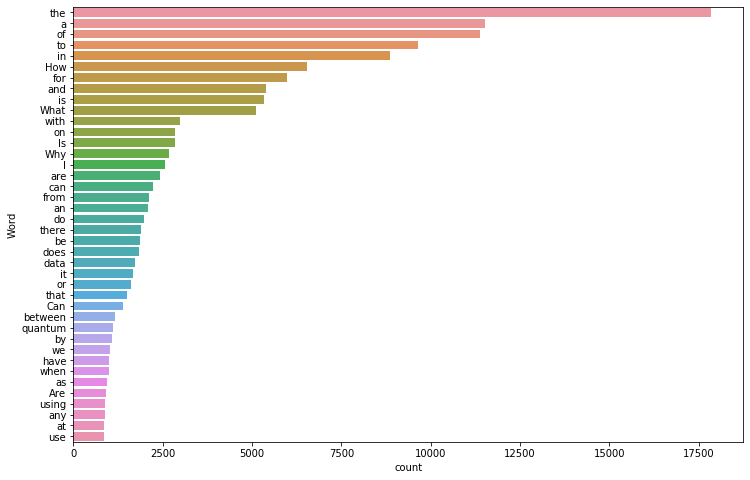

In [6]:
freq_words(df['question_body'], terms=40)

The most frequent words are mostly comprise stop words; no need to update the stop word list.

In [7]:
#function to find the part-of-speech tag
def find_pos(token_list):
    for word, tag in pos_tag(token_list):
        if tag.startswith('N'):
            pos = 'n'
        elif tag.startswith('V'):
            pos = 'v'
        elif tag.startswith('R'):
            pos = 'r'
        else:
            pos = 'a'
    return pos

In [8]:
#one stop shop function to clean up the text
def clean_text(text):
    
    cleanText=text
    
    # clean html links on the body
    html = re.compile('<[^>]*>') # remove everything inside the html tags
   
    cleanText = re.sub(html, ' ', str(cleanText))
    
    # remove stopwords and lemmatize nouns
    tokens = simple_preprocess(cleanText) 
    # remove new line, lowercase, keep alphabet, remove punctuation and special characters 
    #- all taken care by gensim's simple preprocess
    
            
    cleanTokens = [lemmatizer.lemmatize(token, 
                            pos=find_pos(token)) for token in tokens if not token in stop_words and len(token) > 2]
    cleanText = ' '.join(cleanTokens)

    return cleanText

In [9]:
df['clean_body'] = df['question_body'].apply(lambda x: clean_text(x))

## Modelling
### Algorithm Selection
[Back to top](#Table-of-Content)

We will split our data into 60% training, 20% validation, and 20% test. The 20% validation will be used for algorithm selection and hyper parameter tuning. 

In [10]:
#allocate 20% as test, 20% as validation
X, xTest, Y, yTest = train_test_split(df['clean_body'], df['forum'],test_size=0.2, random_state = 202107)
xTrain, xVal, yTrain, yVal = train_test_split(X, Y, test_size=0.25, random_state = 202107)

In [11]:
#initiate vectorizer
countV = CountVectorizer(analyzer='word', ngram_range=(1,2), stop_words='english')
tfidfV = TfidfVectorizer(analyzer='word', ngram_range=(1,2), stop_words='english')
#tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')

#make the these two for choosing algorithm and hyperparameters
xVal_countVec = countV.fit_transform(xVal)
xVal_tfidfVec = tfidfV.fit_transform(xVal)

In [12]:
rForest=RandomForestClassifier(random_state=202107)
knn=KNeighborsClassifier(n_neighbors=9)
multiBayes=MultinomialNB()
boostTree=GradientBoostingClassifier(random_state=202107)
mlp=MLPClassifier(random_state=202107)

models = [knn, rForest, multiBayes, boostTree, mlp]

In [13]:
def get_model_cv(model_list, features_vec, labels, scoring, cv):   

    #build a df for the cv results
    df_cv = pd.DataFrame(index=range(cv * len(model_list)))
    entries = []
    
    for model in model_list:
        model_name = model.__class__.__name__
            
        performance = cross_val_score(model, features_vec, labels, scoring=scoring, cv=cv)
    
        for fold_idx, accuracy in enumerate(performance):
            entries.append((model_name, fold_idx, accuracy))
            
    
    df_cv = pd.DataFrame(entries, columns=['modelName', 'foldIndex', 'Performance'])
    
    return df_cv

Given the classes are slightly imbalanced, we will choose `f1_weighted` as the performance measure. `f1_weighted` calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters `f1_macro` to account for label imbalance.

To speed up the model selection process, we will use the much smaller `validation` dataset and do a 3-fold cross validation, to find out the best suitable algorithm.

In [14]:
df_model_cv_count=get_model_cv(model_list=models, features_vec=xVal_countVec, labels=yVal, 
                               scoring='f1_weighted', cv=3)

In [15]:
df_model_cv_tfidf=get_model_cv(model_list=models, features_vec=xVal_tfidfVec, labels=yVal, 
                               scoring='f1_weighted', cv=3)

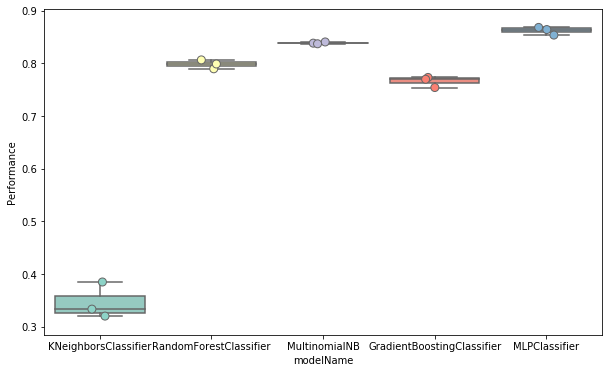

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(x='modelName', y='Performance', data=df_model_cv_count, palette='Set3')
sns.stripplot(x='modelName', y='Performance', data=df_model_cv_count, 
              size=8, jitter=True, edgecolor="gray", linewidth=1, palette='Set3')
plt.show()

`Count` vectoriser counts the frequency of all words in our corpus, sorts them and grabs the most recurring features (using max_features hyperparameter). It works well with **Multinomial Bayes** (MB) as MB expects count-like discrete features. However the count vectoriser might be biased as it might leave out some of the important but less frequent words. 

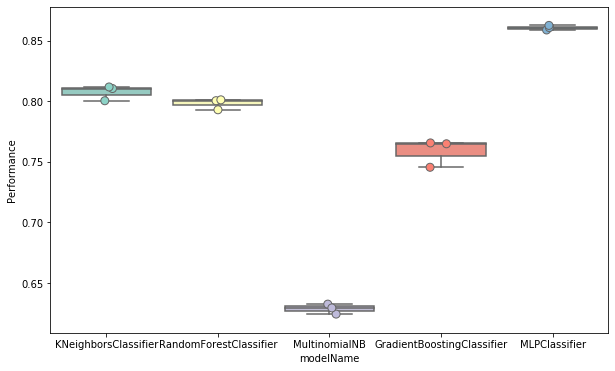

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(x='modelName', y='Performance', data=df_model_cv_tfidf, palette='Set3')
sns.stripplot(x='modelName', y='Performance', data=df_model_cv_tfidf, 
              size=8, jitter=True, edgecolor="gray", linewidth=1, palette='Set3')
plt.show()

At a glance, **Multi-layer Perceptron**, or MLP classifier seems to be the most suitable algorithm. Using `count` or `tfidf` vectorisation seems to generate very similar outcome. But considering the bias mentioned above, we will take this algorithm and use `tfidf `vectorisation to see whether we can improve the performance further.

### Hyperparameter Tuning
[Back to top](#Table-of-Content)

As we have a very large dataset, training on local machine will be hard, so we will only select a few hyperparameters to tune.

In [18]:
#Build this for hyperparameter tuning
pipeline_tune = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', stop_words='english')),
    ('mlp', MLPClassifier(random_state=202108))
        ])
#pipeline_tune.get_params().keys() -- use this to see the keys of all hyperparameters

In [19]:
#used for grid search
parameters_1 = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2,2)],
    'mlp__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,100,100)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__learning_rate': ['constant','adaptive']
    }

#used for bayesian search - bayesian search cannot do tuples
parameters_2 = {
    'mlp__alpha': (0.0001, 0.05, 'log-uniform'), #L2 penalty
    }

In [20]:
grid_search = GridSearchCV(pipeline_tune, parameters_1, scoring='f1_weighted', cv=3, n_jobs=2, verbose=3)
grid_search_result=grid_search.fit(xVal, yVal)

print("Best parameters set:")
print (grid_search_result.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  8.4min
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed: 230.9min finished


Best parameters set:
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (100, 100, 100), 'mlp__learning_rate': 'constant', 'tfidf__ngram_range': (1, 2)}


In [21]:
grid_search_result.cv_results_['mean_test_score']

array([0.85823408, 0.86448445, 0.57965905, 0.85823408, 0.86448445,
       0.57965905, 0.85455573, 0.86449038, 0.57599476, 0.85455573,
       0.86449038, 0.57599476, 0.85785566, 0.86495962, 0.57808742,
       0.85785566, 0.86495962, 0.57808742, 0.8391397 , 0.84486702,
       0.57541667, 0.8391397 , 0.84486702, 0.57541667, 0.82292052,
       0.8488439 , 0.56926383, 0.82292052, 0.8488439 , 0.56926383,
       0.84987596, 0.85849388, 0.57743086, 0.84987596, 0.85849388,
       0.57743086])

In [24]:
pipeline_tune_adjusted = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1,2), stop_words='english')),
    ('mlp', MLPClassifier(activation='tanh', hidden_layer_sizes=(100,100,100), learning_rate = 'constant',
                          random_state=202108))
        ])

bayes_search = BayesSearchCV(pipeline_tune_adjusted, parameters_2, scoring='f1_weighted', n_iter=10, 
                             cv=3, n_jobs=2, verbose=1) 
bayes_search_result=bayes_search.fit(xVal, yVal)


print("Best parameters set:")
print (bayes_search_result.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  4.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  3.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 24.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  4.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  2.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 13.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  2.8min finished


Best parameters set:
OrderedDict([('mlp__alpha', 0.0015956499568491737)])


In [25]:
bayes_search_result.cv_results_['mean_test_score'] 

[0.8649596173837265,
 0.8612309820968084,
 0.864947228512706,
 0.8617688147199143,
 0.8556084196918452,
 0.8624121922266311,
 0.865916610535382,
 0.8655670346538983,
 0.8510723366518332,
 0.8640403157060252]

### Prediction
[Back to top](#Table-of-Content)

In [26]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1,2), stop_words='english')),
    ('mlp', MLPClassifier(activation ='tanh', alpha=0.0016, hidden_layer_sizes =(100,100,100), 
                         learning_rate= 'constant', random_state=202107))
        ])

In [27]:
pipeline.fit(xTrain, yTrain)
prediction = pipeline.predict(xTest)
print('Test f1 score is {:.2%}'.format(f1_score(yTest, prediction, average='weighted')))

Test f1 score is 88.83%


In [28]:
print('Test accuracy score is {:.2%}'.format(accuracy_score(yTest, prediction)))

Test accuracy score is 88.75%


In [29]:
joblib.dump(pipeline, 'forum_trained_pipeline.joblib')

['forum_trained_pipeline.joblib']

The model is able to generalise quite well in the test dataset with a predictive power of 91% (note f1 score is a balance between recall and precision). We will export this model.

## Next Step
[Back to top](#Table-of-Content)

To further improve model performance, we can look into:

  * **Resampling**. Use resampling techniques (up-sampling, down-sampling, SMOTE) to rebalance the classes in forum type.
  * **Fully customised neural networks with Keras**. Build sequential models from scratch, experiment to see what could offer better performance.
  * **Retune hyperparameters**. Test a wider range of hyperparameters on kubernetes clusters.